In [1]:
import pandas as pd

In [2]:

df = pd.read_csv('iter.csv')


In [3]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...
...,...,...
9735,CCATTTCCCACACGAGAGCCCGGCTTTCCTGTCACATTTGGTAAGG...,AGGCTAACGCCTTTATTATATAACCACTCTTAGCCCATAGGACTAC...
9736,TTGATAGGTCATTTACGGCGCGCGAGCCGCATAGGGTAGTAGGGAT...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9737,GTTAGTGACCTAGCCGGGCTATTGGCGAGACTTACCTAACGGAGTT...,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...
9738,CTGTTCAGACGACGATATACGGCCCTGCATTGTATTGTAAAAGCGT...,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...


In [4]:
from tqdm import tqdm


In [5]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [6]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [7]:
import difflib


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [9]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 9740/9740 [00:00<00:00, 58780.61it/s]


[7175, 7126, 7167, 7196, 7180, 7112, 7200, 7163, 7140, 7233, 7212, 7229, 7235, 7125, 7156, 7163, 7218, 7191, 7169, 7213, 7220, 7218, 7248, 7278, 7204, 7217, 7168, 7149, 7212, 7179, 7188, 7153, 7215, 7152, 7207, 7198, 7226, 7209, 7221, 7185, 7155, 7243, 7218, 7121, 7194, 7132, 7284, 7181, 7179, 7212, 7214, 7195, 7142, 7123, 7178, 7168, 7246, 7265, 7275, 7228, 7243, 7198, 7240, 7182, 7223, 7149, 7228, 7172, 7187, 7251, 7258, 7197, 7258, 7194, 7252, 7136, 7202, 7201, 7265, 7185, 7262, 7196, 7198, 7272, 7177, 7186, 7232, 7253, 7161, 7142, 7243, 7172, 7220, 7180, 7210, 7147, 7142, 7219, 7203, 7242, 7223, 7137, 7186, 7197, 7180, 7224, 7177, 7125, 7120, 6804]


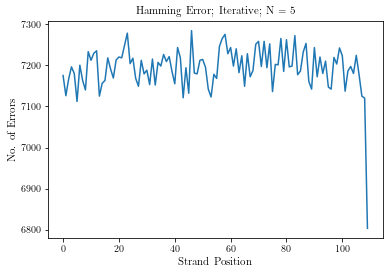

In [10]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; Iterative; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-iter-hamming.pdf', bbox_inches='tight')

In [11]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 9740/9740 [00:13<00:00, 697.53it/s]


In [12]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


C -> AAAA 6
 -> CCAAC 6
 -> CCTGC 6
 -> CATG 6
 -> CACCA 6
GGCGC ->  6
GTGTA ->  6
A -> GTGG 6
 -> AGAGT 6
 -> CACAA 6
GGCTA ->  6
GTGT -> C 6
CGTCG ->  6
GAC -> TT 6
T -> GGCC 6
 -> TAAAA 6
GGTG -> C 6
T -> GCCA 6
 -> ACAAC 6
CGCCC ->  6
CGCCAG ->  6
 -> GGAGT 6
AGAGG ->  6
C -> AAGG 6
 -> CGAGG 6
 -> AATTA 6
T -> GGAG 6
 -> GGAGG 6
AAAG -> T 6
 -> TGTCG 6
GTGGA ->  6
 -> AAGGT 6
 -> TAAGA 6
GGGGA ->  6
GGCTG ->  6
TTATA ->  6
 -> AGGTT 6
 -> AATTT 6
AGA -> CT 6
 -> TTTTA 6
TTAT -> C 6
TGATT ->  6
 -> GGGCC 6
C -> TATA 6
AG -> CCC 6
CA -> TTG 6
 -> TCCCT 6
 -> CAGAC 6
 -> GGGAA 6
A -> TCTC 6
 -> GTCCC 6
 -> CGTTT 6
 -> GTCCG 6
 -> GCCGG 6
C -> TTTT 6
CGG -> AA 6
 -> CGTCT 6
GAGGA ->  6
GTTCG ->  6
TTGGG ->  6
 -> CATAA 6
CGCGC ->  6
C -> TTGT 6
T -> CCCA 6
 -> GACACA 6
CGGTG ->  6
AATTA ->  6
GAGAA ->  6
 -> CTTCT 6
C -> GAGA 6
C -> GAT 6
GAGAG ->  6
 -> TGTAG 6
T -> AGGA 6
 -> CACGG 6
GAGC -> T 6
 -> TAACA 6
 -> AATTC 6
GGG -> AA 6
CAAC -> G 6
 -> AGATA 6
 -> GAGTA 6
TTGTG ->  6
TT -

 -> TC @ 66 6
 -> CG @ 98 6
 -> AA @ 88 6
A -> G @ 101 6
 -> AC @ 20 6
GG ->  @ 91 6
CA ->  @ 11 6
 -> TG @ 18 6
 -> TC @ 59 6
 -> GG @ 42 6
A -> G @ 58 6
 -> GAC @ 0 6
 -> GAA @ 0 6
 -> AC @ 19 6
GA ->  @ 28 6
 -> AC @ 18 6
C -> G @ 71 6
 -> AC @ 13 6
 -> CTT @ 2 6
 -> AA @ 45 6
AA ->  @ 92 6
AA ->  @ 90 6
CA ->  @ 55 6
TAA ->  @ 15 6
 -> AA @ 44 6
 -> TT @ 32 6
 -> TC @ 54 6
AA ->  @ 85 6
CA ->  @ 16 6
 -> TT @ 17 6
AT ->  @ 30 6
 -> TC @ 28 6
 -> TC @ 29 6
 -> TC @ 3 6
 -> GT @ 85 6
CC ->  @ 27 6
 -> TTT @ 7 6
 -> TT @ 21 6
 -> TC @ 32 6
 -> AA @ 43 6
 -> TT @ 31 6
A -> G @ 37 6
 -> AC @ 21 6
 -> TC @ 5 6
 -> TG @ 2 6
CA ->  @ 15 6
 -> CC @ 34 6
TAT ->  @ 110 6
G -> A @ 104 6
CA ->  @ 14 6
 -> TT @ 29 6
 -> GA @ 96 6
T -> A @ 74 6
T -> A @ 76 6
TAT ->  @ 3 6
AA ->  @ 83 6
 -> TG @ 74 6
A -> C @ 16 6
GA ->  @ 74 6
 -> GG @ 53 6
CC ->  @ 97 6
 -> TT @ 52 6
T -> G @ 51 6
C -> G @ 9 6
 -> TT @ 53 6
 -> AT @ 50 6
GA ->  @ 85 6
CT ->  @ 59 6
T -> C @ 101 6
 -> AT @ 43 6
 -> AT @ 42 6
 -> 

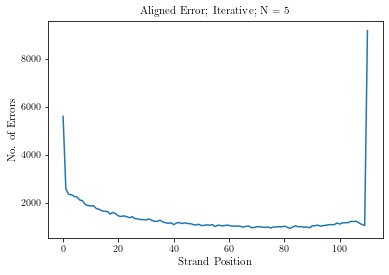

In [13]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; Iterative; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-iter-aligned.pdf', bbox_inches='tight')

In [14]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [15]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [16]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[227, 54, 62, 73, 75, 60, 65, 73, 47, 51, 38, 51, 43, 36, 40, 48, 39, 35, 39, 44, 28, 42, 35, 33, 38, 38, 23, 33, 31, 24, 23, 38, 22, 24, 35, 25, 22, 31, 29, 31, 29, 24, 30, 25, 29, 21, 21, 18, 16, 26, 23, 25, 14, 19, 24, 21, 26, 24, 22, 21, 20, 20, 24, 17, 20, 23, 22, 32, 21, 17, 26, 25, 15, 17, 17, 18, 27, 18, 26, 26, 20, 22, 19, 16, 27, 19, 22, 19, 27, 21, 12, 23, 20, 25, 22, 28, 26, 20, 22, 27, 30, 22, 31, 27, 28, 44, 37, 32, 27, 48, 43]
[166, 47, 63, 71, 64, 73, 54, 52, 56, 50, 47, 44, 49, 51, 45, 40, 44, 27, 30, 26, 37, 39, 47, 33, 24, 34, 40, 36, 28, 36, 31, 31, 29, 32, 26, 25, 29, 30, 15, 29, 22, 21, 17, 29, 32, 25, 25, 25, 19, 20, 22, 20, 14, 22, 17, 17, 24, 22, 19, 17, 23, 22, 31, 22, 26, 22, 25, 19, 20, 18, 21, 26, 25, 22, 17, 19, 24, 19, 16, 24, 22, 25, 23, 22, 24, 26, 15, 21, 14, 18, 11, 23, 19, 18, 29, 26, 26, 32, 22, 29, 32, 31, 28, 24, 26, 37, 27, 23, 32, 54, 72]
[211, 49, 67, 59, 54, 56, 57, 59, 62, 54, 47, 47, 47, 39, 48, 40, 49, 32, 34, 35, 28, 35, 38, 29, 25, 31, 36

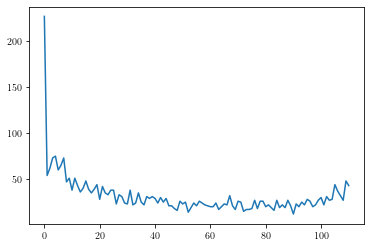

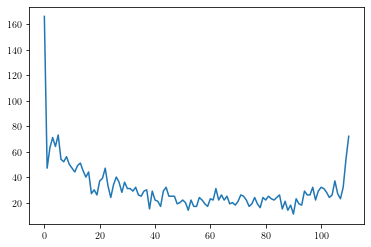

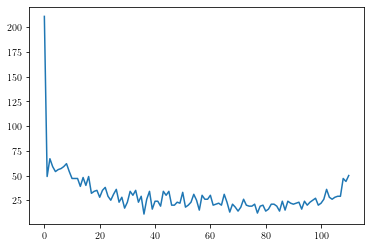

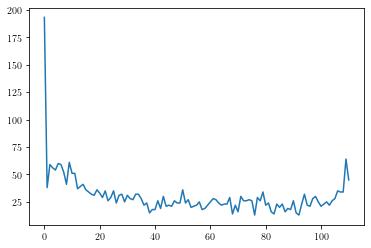

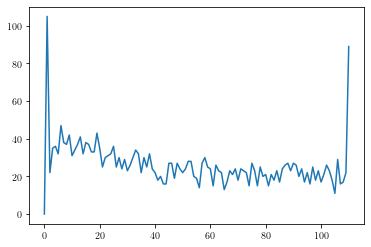

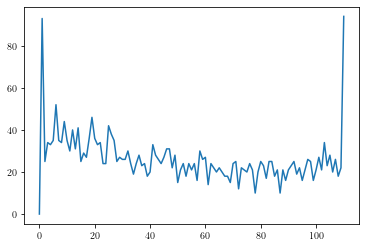

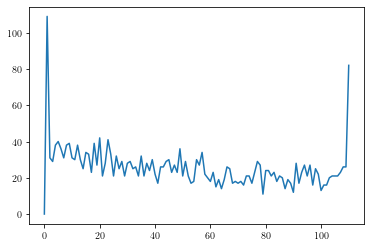

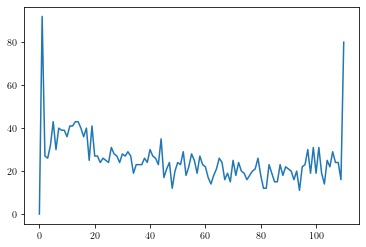

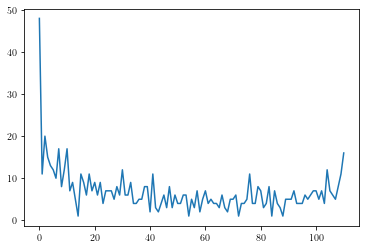

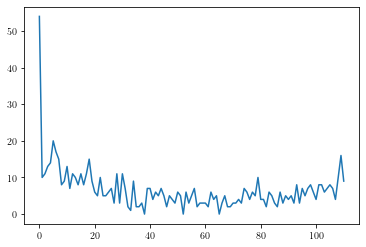

In [17]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [18]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)